In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

#from IPython.display import display, Latex, clear_output

In [2]:
# Modification to plot format
rcvals = {'xtick.minor.visible': True, 'ytick.minor.visible': True,
          'xtick.direction': 'in', 'ytick.direction': 'in',
          'xtick.top': True, 'ytick.right': True, 'font.family': ['serif'],
          'xtick.major.size': 6, 'ytick.major.size': 6,
          'xtick.minor.size': 3, 'ytick.minor.size': 3,
          'image.interpolation': 'nearest', 'image.origin': 'lower',
          'figure.figsize': [8,6], 'mathtext.fontset':'cm'}
matplotlib.rcParams.update(rcvals)

In [3]:
# WebbPSF
import webbpsf

# Interpolation and extrapolation
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.ndimage import rotate

# pySIAF stuff for plotting
from pysiaf.siaf import Siaf
from pysiaf.siaf import plot_main_apertures

In [4]:
# SI Zernike data
from astropy.table import Table

data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = data_dir + 'si_zernikes_isim_cv3.fits'

# Read in table data
ztable_full = Table.read(zernike_file)

# Interpolate within bounds of CV3 measurements

In [5]:
def gen_zgrid(lookup_name, ztable_full, zkey='Zernike_4'):
    """Gridded Zernike Data
    
    Use `scipy.interpolate.griddata` to generate a fine meshed
    grid. Return the xgrid (V2) and ygrid (V3) values along with
    the corresponding 2D grid of Zernike values. The `zgrid`
    values will include NaN's for data outside of the `ztable_full`
    range of data recorded in ISIM CV3.

    Parameters
    ==========
    lookup_name : string
        Instrument name including: 
        'Guider1', 'Guider2', 'MIRI', 'NIRISS', 'NIRSpec',
        'NIRCamLWA', 'NIRCamLWB', 'NIRCamSWA', 'NIRCamSWB'
    ztable_full : Table
        Astropy Table of 'si_zernikes_isim_cv3.fits'
    zkey : string
        Zernike component to create, default: 'Zernike_4' (focus)
    """

    # Filter full table
    ztable = ztable_full[ztable_full['instrument'] == lookup_name]
    
    # V2/V3 coordinate axes
    v2 = ztable['V2']
    v3 = ztable['V3']
    # Corresponding zernike values
    zvals = ztable[zkey]

    # Create fine mesh grid
    dstep = 1. / 60. # 1" steps
    xgrid = np.arange(v2.min(), v2.max()+dstep, dstep)
    ygrid = np.arange(v3.min(), v3.max()+dstep, dstep)
    X, Y = np.meshgrid(xgrid,ygrid)

    # Cubic interpolation of all points
    zgrid = griddata((v2, v3), zvals, (X, Y), method='cubic')
    
    return xgrid, ygrid, zgrid

def plot_cv3_data(ax, zkey='Zernike_4', plot_aps=True):
    
    names = ['Guider1', 'Guider2', 'MIRI', 'NIRISS', 'NIRSpec',
         'NIRCamLWA', 'NIRCamLWB']#, 'NIRCamSWA', 'NIRCamSWB']

    for lookup_name in names:
        

        # Gridded data from ISIM CV3 measurements
        xgrid, ygrid, zgrid = gen_zgrid(lookup_name, ztable_full, zkey=zkey)
        zmin, zmax = np.nanmin(zgrid), np.nanmax(zgrid)

        extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()]) * 60
        ax.imshow(zgrid, extent=extent, vmin=zmin, vmax=zmax)

        # V2/V3 Points
        ztable = ztable_full[ztable_full['instrument'] == lookup_name]
        v2, v3 = (ztable['V2'], ztable['V3'])
        ax.plot(v2*60, v3*60, ls='none', marker='x', color='C1')

    if plot_aps: 
        plot_main_apertures(ax=ax, fill=False, mark_ref=False)
    ax.set_xlim([600,-600])
    ax.set_ylim([-800,-250])
    ax.set_title("griddata with method='cubic' ({})".format(zkey))


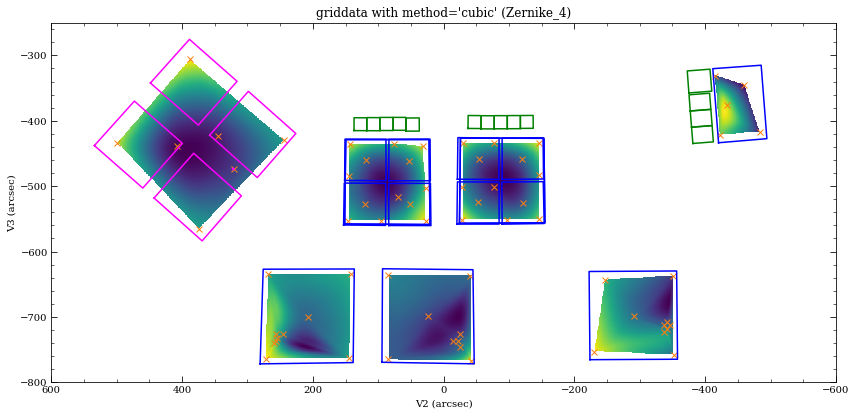

In [6]:
# Plot gridded CV3 data
fig, ax = plt.subplots(1,1, figsize=(12,6))

plot_cv3_data(ax, zkey='Zernike_4')
    
fig.tight_layout()

# Extrapolate using RegularGridInterpolator

In [7]:
# To extrapolate outside the measured field points, we proceed 
# in two steps.  This first creates a fine-meshed cubic fit 
# over the known field points, fixes any NaN's using 
# RegularGridInterpolator, then again uses  RegularGridInterpolator 
# on the fixed data to extrapolate the requested field point.

# In principle, the first call of RegularGridInterpolator can be 
# used to extrapolate the requested field point to eliminate 
# the intermediate step, but this method enables use of all the 
# real data rather than the trimmed data set.

def _fix_zgrid_NaNs(xgrid, ygrid, zgrid, rot_ang=0):
    """Fix NaN's in Zernike Grid
    
    We trim NaN's within `zgrid`, then generate an extrapolation function
    using `RegularGridInterpolator`. A rotation angle can also be specified
    to maximize the number of remaining data points due to irregular
    polygons of the real `zgrid` data.
    
    Returns `zgrid` with the NaN's fixed using the extrapolation function.
    
    Parameter
    =========
    xgrid : ndarray
        1D V2 regular grid information
    ygrid : ndarray
        1D V3 regular grid information
    zgrid : ndarray
        2D Zernike grid
    rot_ang : float
        Option to rotate grid data for more optimal
        trimming of NaN's.
    """
            
    # Rotate zgrid
    if rot_ang != 0:
        zgrid = rotate(zgrid, rot_ang, reshape=False, order=1, cval=np.nan)
        
    # There will be some NaN's along the border that need to be replaced
    ind_nan = np.isnan(zgrid)
    # Remove rows/cols with NaN's
    xgrid2, ygrid2, zgrid2 = _trim_nan_image(xgrid, ygrid, zgrid)
    
    # Create regular grid interpolator function for extrapolation of NaN's
    func = RegularGridInterpolator((ygrid2,xgrid2), zgrid2, method='linear',
                                   bounds_error=False, fill_value=None)

    # Replace NaNs
    X, Y = np.meshgrid(xgrid,ygrid)
    pts = np.array([Y[ind_nan], X[ind_nan]]).transpose()
    zgrid[ind_nan] = func(pts)

    # De-rotate clipped zgrid image and redo RegularGridInterpolator
    if rot_ang != 0:
        # De-rotate
        zgrid = rotate(zgrid, -rot_ang, reshape=False, order=1, cval=np.nan)
        # There will be some NaNs along the border that need to be replaced
        ind_nan = np.isnan(zgrid)
        # Remove rows/cols 1 by 1 until no NaNs
        xgrid2, ygrid2, zgrid2 = _trim_nan_image(xgrid, ygrid, zgrid)

        # Create regular grid interpolator function for extrapolation of NaN's
        func = RegularGridInterpolator((ygrid2,xgrid2), zgrid2, method='linear',
                                       bounds_error=False, fill_value=None)

        # Replace NaNs
        pts = np.array([Y[ind_nan], X[ind_nan]]).transpose()
        zgrid[ind_nan] = func(pts)
        
    return zgrid

def _trim_nan_image(xgrid, ygrid, zgrid):
    """NaN Trimming of Image
    
    Remove rows/cols with NaN's while trying to preserve
    the maximum footprint of real data.
    """
    
    xgrid2, ygrid2, zgrid2 = xgrid, ygrid, zgrid
    
    # Find a reasonable place to crop a rectangule subsection free of NaN's
    # Iterative cropping
    ndiff = 5
    while np.isnan(zgrid2.sum()):
        # Make sure ndiff is not negative
        if ndiff<0:
            break

        npix = zgrid2.size

        # Create a mask of NaN'ed values
        nan_mask = np.isnan(zgrid2)
        nrows, ncols = nan_mask.shape
        # Determine number of NaN's along each row and col
        num_nans_cols = nan_mask.sum(axis=0)
        num_nans_rows = nan_mask.sum(axis=1)

        # Look for any appreciable diff row-to-row/col-to-col
        col_diff = num_nans_cols - np.roll(num_nans_cols,-1) 
        row_diff = num_nans_rows - np.roll(num_nans_rows,-1)
        # For edge wrapping, just use last minus previous
        col_diff[-1] = col_diff[-2]
        row_diff[-1] = row_diff[-2]

        # Keep rows/cols composed mostly of real data 
        # and where number of NaN's don't change dramatically
        xind_good = np.where( ( np.abs(col_diff) <= ndiff  ) & 
                              ( num_nans_cols < 0.5*nrows ) )[0]
        yind_good = np.where( ( np.abs(row_diff) <= ndiff  ) & 
                              ( num_nans_rows < 0.5*ncols ) )[0]
        # get border limits
        x1, x2 = (xind_good.min(), xind_good.max()+1)
        y1, y2 = (yind_good.min(), yind_good.max()+1)
    
        # Trim of NaN borders
        xgrid2 = xgrid2[x1:x2]
        ygrid2 = ygrid2[y1:y2]
        zgrid2 = zgrid2[y1:y2,x1:x2]
        
        # Check for convergence
        # If we've converged, reduce 
        if npix==zgrid2.size:
            ndiff -= 1
                
    # Last ditch effort in case there are still NaNs
    # If so, remove rows/cols 1 by 1 until no NaNs
    while np.isnan(zgrid2.sum()):
        xgrid2 = xgrid2[1:-1]
        ygrid2 = ygrid2[1:-1]
        zgrid2 = zgrid2[1:-1,1:-1]
            
    return xgrid2, ygrid2, zgrid2



In [8]:
def gen_zgrid_extr(lookup_name, ztable_full, zkey='Zernike_4'):

        # Gridded data from ISIM CV3 measurements
        xgrid, ygrid, zgrid = gen_zgrid(lookup_name, ztable_full, zkey='Zernike_4')

        # Want to rotate zgrid image for some SIs to minimize NaN clipping
        if 'NIRSpec' in lookup_name:
            rot_ang = 43
        elif 'MIRI' in lookup_name:
            rot_ang = -5
        elif 'NIRISS' in lookup_name:
            rot_ang = 2
        else:
            rot_ang = 0

        # Fixed NaN's
        zgrid_fix = _fix_zgrid_NaNs(xgrid, ygrid, zgrid, rot_ang=rot_ang)
        
        return xgrid, ygrid, zgrid_fix

def plot_extr_data(ax, zkey='Zernike_4', plot_aps=True):
    
    names = ['Guider1', 'Guider2', 'MIRI', 'NIRISS', 'NIRSpec',
         'NIRCamLWA', 'NIRCamLWB']#, 'NIRCamSWA', 'NIRCamSWB']

    for lookup_name in names:

        # Extrapolate data (fixed NaN's)
        xgrid, ygrid, zgrid = gen_zgrid_extr(lookup_name, ztable_full, zkey=zkey)
        zmin, zmax = np.nanmin(zgrid), np.nanmax(zgrid)

        extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()]) * 60
        ax.imshow(zgrid, extent=extent, vmin=zmin, vmax=zmax)

        # V2/V3 Points
        ztable = ztable_full[ztable_full['instrument'] == lookup_name]
        v2, v3 = (ztable['V2'], ztable['V3'])
        ax.plot(v2*60, v3*60, ls='none', marker='x', color='C1')

    if plot_aps: 
        plot_main_apertures(ax=ax, fill=False, mark_ref=False)
    ax.set_xlim([600,-600])
    ax.set_ylim([-800,-250])
    ax.set_title("NaN's Trimmed and Fixed ({})".format(zkey))

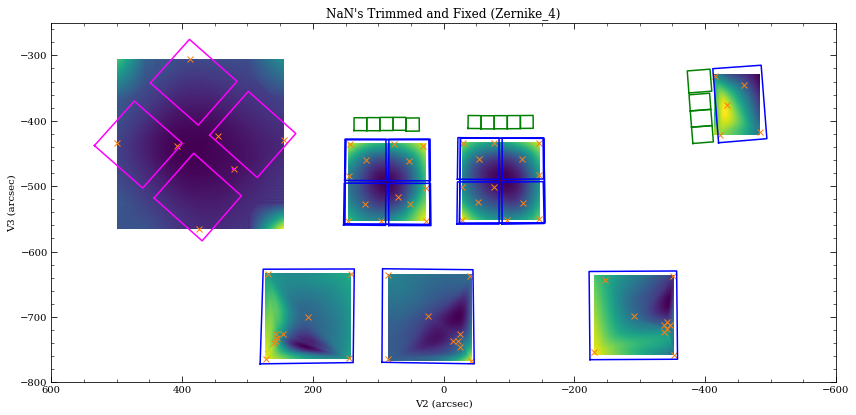

In [9]:
# Plot gridded CV3 data
fig, ax = plt.subplots(1,1, figsize=(12,6))
plot_extr_data(ax, zkey='Zernike_4')
fig.tight_layout()

# Extrapolate to Full FoVs

In [10]:
def full_field_interp(lookup_name, func):
    """Create Zernike map over full instrument FoV
    
    lookup_name : 
    """
    
    if 'NIRCam' in lookup_name:
        siaf = Siaf('nircam')
        siaf.generate_toc()
        ap = siaf['NRCA5_FULL'] if lookup_name=='NIRCamLWA' else siaf['NRCB5_FULL']
    elif 'NIRISS' in lookup_name:
        siaf = Siaf('niriss')
        siaf.generate_toc()
        ap = siaf['NIS_CEN']
    elif 'NIRSpec' in lookup_name:
        siaf = Siaf('nirspec')
        siaf.generate_toc()
        ap = siaf['NRS_FULL_MSA']
    elif 'MIRI'  in lookup_name:
        siaf = Siaf('miri')
        siaf.generate_toc()
        ap = siaf['MIRIM_FULL']
    elif 'Guider' in lookup_name:
        siaf = Siaf('fgs')
        siaf.generate_toc()
        ap = siaf['FGS1_FULL'] if lookup_name=='Guider1' else siaf['FGS2_FULL']

    v2_ref, v3_ref = ap.closed_polygon_points('tel')
    v2_ref /= 60.
    v3_ref /= 60.
    dstep = 1. / 60. # 1" steps
    xgrid = np.arange(v2_ref.min(), v2_ref.max()+dstep, dstep)
    ygrid = np.arange(v3_ref.min(), v3_ref.max()+dstep, dstep)
    X, Y = np.meshgrid(xgrid,ygrid)

    # Cubic interpolation of all points
    pts = np.array([Y.flatten(), X.flatten()]).transpose()
    zgrid_full = func(pts).reshape(X.shape)

    return xgrid, ygrid, zgrid_full

def plot_fullfov_data(ax, zkey='Zernike_4', plot_aps=True):
    
    names = ['Guider1', 'Guider2', 'MIRI', 'NIRISS', 'NIRSpec',
         'NIRCamLWA', 'NIRCamLWB']#, 'NIRCamSWA', 'NIRCamSWB']

    for lookup_name in names:

        # Extrapolate data (fixed NaN's)
        xgrid, ygrid, zgrid = gen_zgrid_extr(lookup_name, ztable_full, zkey=zkey)

        # Final interplation/extrapolation function
        func = RegularGridInterpolator((ygrid,xgrid), zgrid, method='linear',
                                       bounds_error=False, fill_value=None)

        # Extrapolation full field of view according to SIAF info
        xgrid_siaf, ygrid_siaf, zgrid_siaf = full_field_interp(lookup_name, func)
        
        zmin, zmax = np.nanmin(zgrid), np.nanmax(zgrid)

        extent = np.array([xgrid_siaf.min(),xgrid_siaf.max(),
                           ygrid_siaf.min(),ygrid_siaf.max()]) * 60
        ax.imshow(zgrid_siaf, extent=extent, vmin=zmin, vmax=zmax)

        # V2/V3 Points
        ztable = ztable_full[ztable_full['instrument'] == lookup_name]
        v2, v3 = (ztable['V2'], ztable['V3'])
        ax.plot(v2*60, v3*60, ls='none', marker='x', color='C1')

    if plot_aps: 
        plot_main_apertures(ax=ax, fill=False, mark_ref=False)
    ax.set_xlim([600,-600])
    ax.set_ylim([-800,-250])
    ax.set_title("NaN's Trimmed and Fixed ({})".format(zkey))

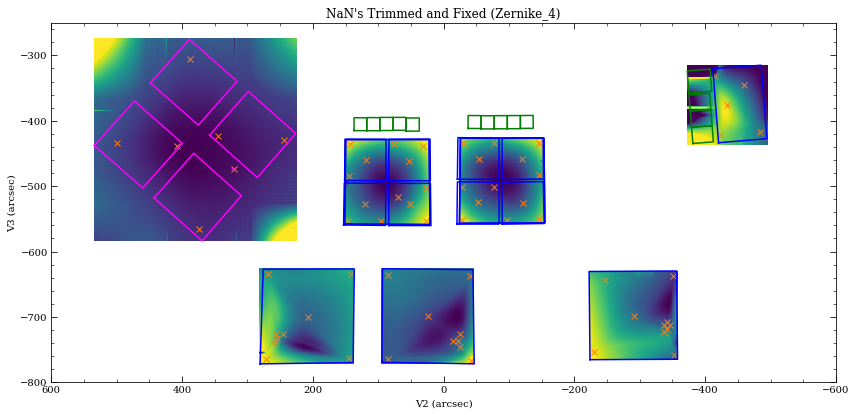

In [11]:
# Plot gridded CV3 data
fig, ax = plt.subplots(1,1, figsize=(12,6))
plot_fullfov_data(ax, zkey='Zernike_4')
fig.tight_layout()

# Plot All Three Steps

In [12]:
def plot_zmaps(ztable_full, zkey='Zernike_4', plot_aps=True, save_fig=False):
    """Plot Zernike WFE maps
    
    zkey : 'Zernike_1' through 'Zernike_36'
    plot_aps : Option to plot SIAF apertures via `plot_main_apertures`
    """
    
    names = ['Guider1', 'Guider2', 'MIRI', 'NIRISS', 'NIRSpec',
             'NIRCamLWA', 'NIRCamLWB']#, 'NIRCamSWA', 'NIRCamSWB']

    fig, axes = plt.subplots(3,1, figsize=(8,10))
    axes = axes.flatten()
    
    plot_cv3_data(axes[0], zkey=zkey, plot_aps=plot_aps)
    plot_extr_data(axes[1], zkey=zkey, plot_aps=plot_aps)
    plot_fullfov_data(axes[2], zkey=zkey, plot_aps=plot_aps)

    fig.tight_layout()
    
    if save_fig:
        fig.savefig("{}.pdf".format(zkey))

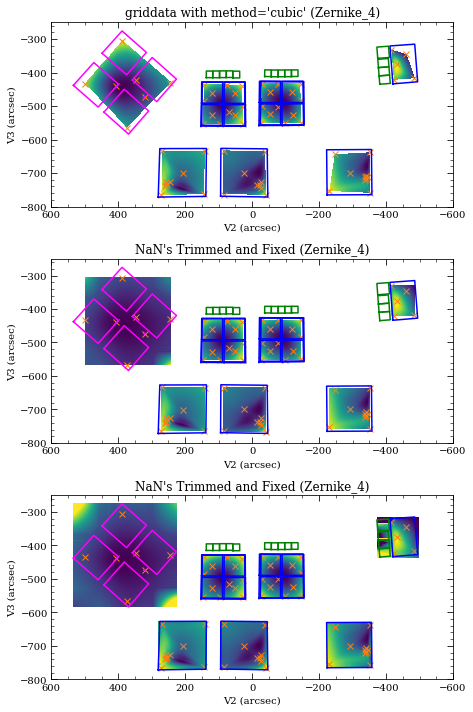

In [13]:
plot_zmaps(ztable_full, zkey='Zernike_4', plot_aps=True)